In [57]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, auc, roc_curve
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


In [58]:
# Check GPU availability
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [59]:
# Load the dataset and visualize images
labels = os.listdir("/kaggle/input/drowsiness-dataset/train")

In [60]:
# Load the data using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30
)

In [61]:
# Load the dataset and split into training and testing sets
directory = "../input/drowsiness-dataset/train"
target_size = (240, 240)
batch_size = 4000  # Adjust batch size as needed

In [62]:
# Load the dataset and split into training and testing sets
data = datagen.flow_from_directory(
    directory,
    target_size=target_size,
    batch_size=batch_size,  # Specify batch size here
    class_mode='categorical',
    subset='training'
)


Found 2321 images belonging to 4 classes.


In [63]:
# Split the data into training and testing sets
x, y = data.next()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [64]:
# Encode the labels using one-hot encoding
label_bin = LabelBinarizer()
y_train = label_bin.fit_transform(y_train)
y_test = label_bin.transform(y_test)

In [65]:
# Create the InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

In [66]:
# Add custom layers for classification on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')
])

In [67]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [68]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                131136    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 21,934,180
Trainable params: 131,396
Non-trainable params: 21,802,784
____________________________________

In [69]:
# Train the model
hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=45)  # Specify batch size here


Epoch 1/100
42/42 [==============================] - 13s 163ms/step - loss: 0.6199 - accuracy: 0.7107 - val_loss: 0.3785 - val_accuracy: 0.7871
Epoch 2/100
42/42 [==============================] - 4s 107ms/step - loss: 0.3829 - accuracy: 0.8044 - val_loss: 0.3057 - val_accuracy: 0.8151
Epoch 3/100
42/42 [==============================] - 5s 110ms/step - loss: 0.3252 - accuracy: 0.8502 - val_loss: 0.3103 - val_accuracy: 0.8387
Epoch 4/100
42/42 [==============================] - 4s 106ms/step - loss: 0.3033 - accuracy: 0.8631 - val_loss: 0.3130 - val_accuracy: 0.8301
Epoch 5/100
42/42 [==============================] - 4s 93ms/step - loss: 0.2700 - accuracy: 0.8718 - val_loss: 0.2881 - val_accuracy: 0.8495
Epoch 6/100
42/42 [==============================] - 4s 95ms/step - loss: 0.2580 - accuracy: 0.8766 - val_loss: 0.2974 - val_accuracy: 0.8452
Epoch 7/100
42/42 [==============================] - 4s 93ms/step - loss: 0.2485 - accuracy: 0.8815 - val_loss: 0.2298 - val_accuracy: 0.8882
E

In [70]:
# Save the model
model.save("drowsiness_inceptionv3.h5")
model.save("drowsiness_inceptionv3.model")

In [71]:
# Plot accuracy and loss
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))

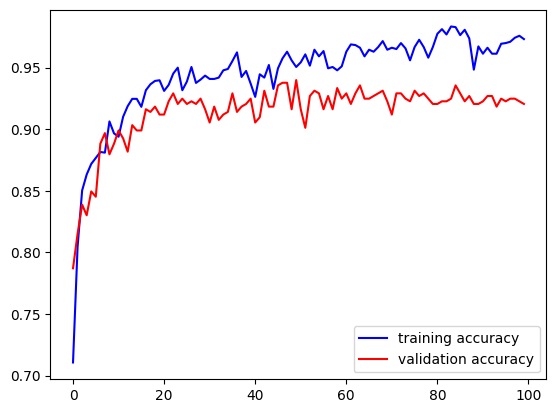

In [72]:
plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()


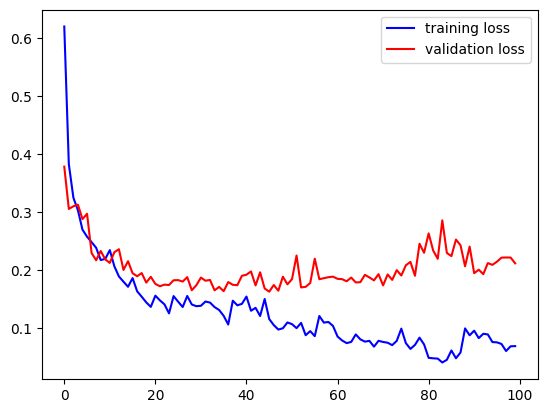

In [73]:
plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()


In [74]:
# Make predictions and evaluate the model
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

15/15 [==============================] - 2s 53ms/step


In [75]:
# Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)


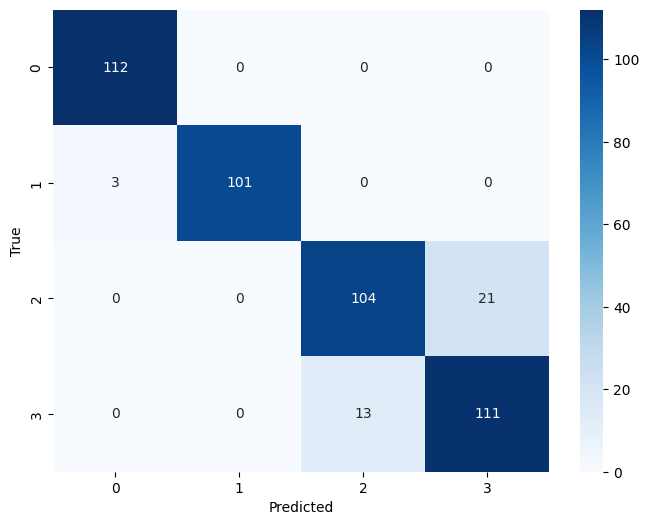

In [76]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [77]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_mtx)

Confusion Matrix:
 [[112   0   0   0]
 [  3 101   0   0]
 [  0   0 104  21]
 [  0   0  13 111]]


In [78]:
# Accuracy Score
accuracy = np.sum(y_true == y_pred_classes) / len(y_true)
print("Accuracy:", accuracy)


Accuracy: 0.9204301075268817


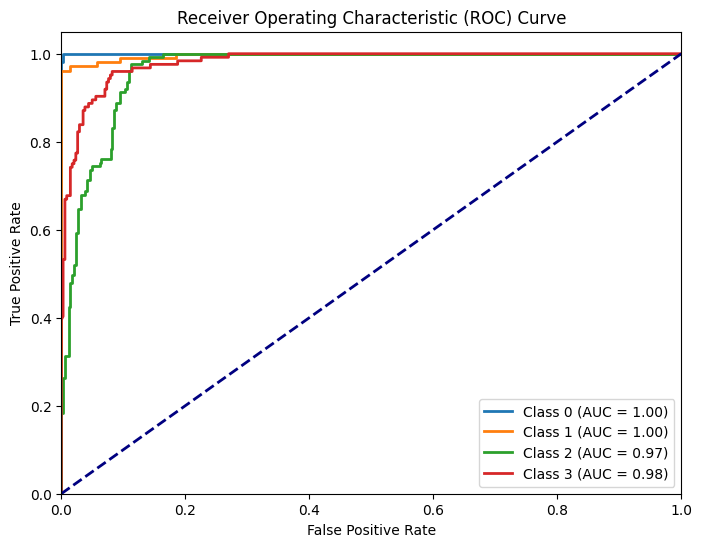

In [79]:
# Compute ROC curves and AUC for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [80]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


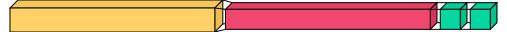

In [81]:
import visualkeras
from tensorflow.keras.layers import ZeroPadding2D
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten

# Now you can use Flatten layer like this:
flatten_layer = Flatten()

# Now you can use batch normalization layer like this:
bn_layer = BatchNormalization()

visualkeras.layered_view(model, type_ignore=[ ZeroPadding2D,BatchNormalization,Flatten,Dropout])

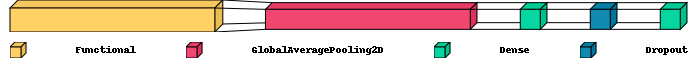

In [82]:
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
visualkeras.layered_view(model, legend=True, spacing=50) 

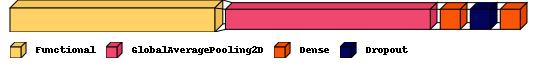

In [83]:
from tensorflow.keras import layers
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'
visualkeras.layered_view(model, legend=True,color_map=color_map)